# Accuracy

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV files
pred_df = pd.read_csv('lane_vehicle_counts.csv', skip_blank_lines=True)
real_df = pd.read_csv('real_lane_vehicle_counts.csv', skip_blank_lines=True)

# Drop rows where Lane is NaN
pred_df = pred_df.dropna(subset=['Lane'])
real_df = real_df.dropna(subset=['Lane'])

# Filter out the TOTAL rows for accuracy calculation
pred_detailed = pred_df[pred_df['Vehicle Type'] != 'TOTAL']
real_detailed = real_df[real_df['Vehicle Type'] != 'TOTAL']

# Print the dataframes for verification
print("Predicted counts:")
print(pred_df)
print("\nReal counts:")
print(real_df)

Predicted counts:
    Lane  Vehicle Type  Count
0    1.0       4-wheel    4.0
1    1.0       6-wheel    1.0
2    1.0         TOTAL    5.0
4    2.0       4-wheel    9.0
5    2.0  6-more-wheel    1.0
6    2.0         TOTAL   10.0
8    3.0       4-wheel    6.0
9    3.0         TOTAL    6.0
11   4.0       4-wheel    5.0
12   4.0         TOTAL    5.0
14   5.0       4-wheel    3.0
15   5.0       6-wheel    1.0
16   5.0         TOTAL    4.0

Real counts:
    Lane Vehicle Type  Count
0    1.0      4-wheel    4.0
1    1.0      6-wheel    1.0
2    1.0        TOTAL    5.0
4    2.0      4-wheel    8.0
5    2.0      6-wheel    1.0
6    2.0        TOTAL    9.0
8    3.0      4-wheel    6.0
9    3.0        TOTAL    6.0
11   4.0      4-wheel    5.0
12   4.0        TOTAL    5.0
14   5.0      4-wheel    3.0
15   5.0      6-wheel    1.0
16   5.0        TOTAL    4.0


## Overall Accuracy Analysis

In [9]:
# Calculate total vehicles across all lanes
pred_total = pred_df[pred_df['Vehicle Type'] == 'TOTAL']['Count'].sum()
real_total = real_df[real_df['Vehicle Type'] == 'TOTAL']['Count'].sum()

# Calculate overall accuracy
overall_accuracy = 100 * (1 - abs(pred_total - real_total) / real_total)
print(f"Total predicted vehicles: {pred_total}")
print(f"Total actual vehicles: {real_total}")
print(f"Overall counting accuracy: {overall_accuracy:.2f}%")

# Create a merged dataframe for comparison
merged_totals = pd.merge(pred_df[pred_df['Vehicle Type'] == 'TOTAL'], 
                         real_df[real_df['Vehicle Type'] == 'TOTAL'], 
                         on='Lane', suffixes=('_pred', '_real'))

# Calculate per-lane accuracy
merged_totals['Accuracy'] = 100 * (1 - abs(merged_totals['Count_pred'] - merged_totals['Count_real']) / merged_totals['Count_real'])
print("\nPer-lane accuracy:")
print(merged_totals[['Lane', 'Count_pred', 'Count_real', 'Accuracy']])

Total predicted vehicles: 30.0
Total actual vehicles: 29.0
Overall counting accuracy: 96.55%

Per-lane accuracy:
   Lane  Count_pred  Count_real    Accuracy
0   1.0         5.0         5.0  100.000000
1   2.0        10.0         9.0   88.888889
2   3.0         6.0         6.0  100.000000
3   4.0         5.0         5.0  100.000000
4   5.0         4.0         4.0  100.000000


## Per Vehicle Type Accuracy

In [10]:
# Merge the detailed dataframes
merged_detailed = pd.merge(pred_detailed, real_detailed, 
                          on=['Lane', 'Vehicle Type'], 
                          suffixes=('_pred', '_real'), how='outer')
merged_detailed = merged_detailed.fillna(0)

# Calculate vehicle type accuracy
merged_detailed['Accuracy'] = 100 * (1 - abs(merged_detailed['Count_pred'] - merged_detailed['Count_real']) / 
                                  merged_detailed['Count_real'].replace(0, 1))
merged_detailed['Accuracy'] = merged_detailed['Accuracy'].clip(lower=0)

print("Vehicle type detection accuracy:")
print(merged_detailed[['Lane', 'Vehicle Type', 'Count_pred', 'Count_real', 'Accuracy']])

# Calculate average accuracy by vehicle type
vehicle_type_accuracy = merged_detailed.groupby('Vehicle Type')['Accuracy'].mean()
print("\nAverage accuracy by vehicle type:")
print(vehicle_type_accuracy)

Vehicle type detection accuracy:
   Lane  Vehicle Type  Count_pred  Count_real  Accuracy
0   1.0       4-wheel         4.0         4.0     100.0
1   1.0       6-wheel         1.0         1.0     100.0
2   2.0       4-wheel         9.0         8.0      87.5
3   2.0  6-more-wheel         1.0         0.0       0.0
4   2.0       6-wheel         0.0         1.0       0.0
5   3.0       4-wheel         6.0         6.0     100.0
6   4.0       4-wheel         5.0         5.0     100.0
7   5.0       4-wheel         3.0         3.0     100.0
8   5.0       6-wheel         1.0         1.0     100.0

Average accuracy by vehicle type:
Vehicle Type
4-wheel         97.500000
6-more-wheel     0.000000
6-wheel         66.666667
Name: Accuracy, dtype: float64


## Visualization

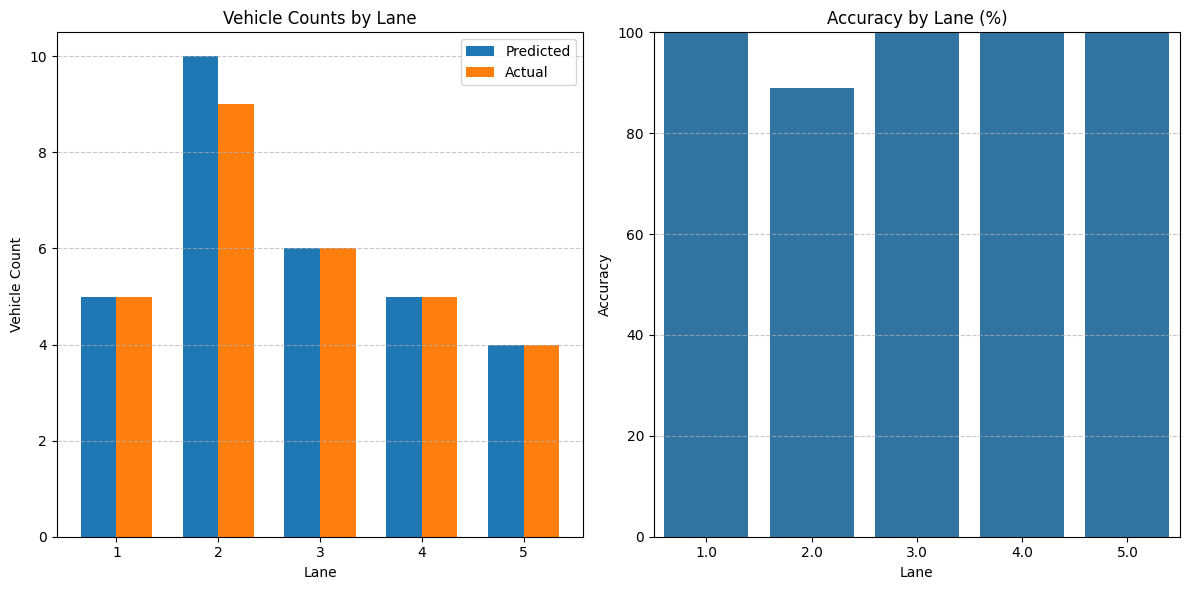

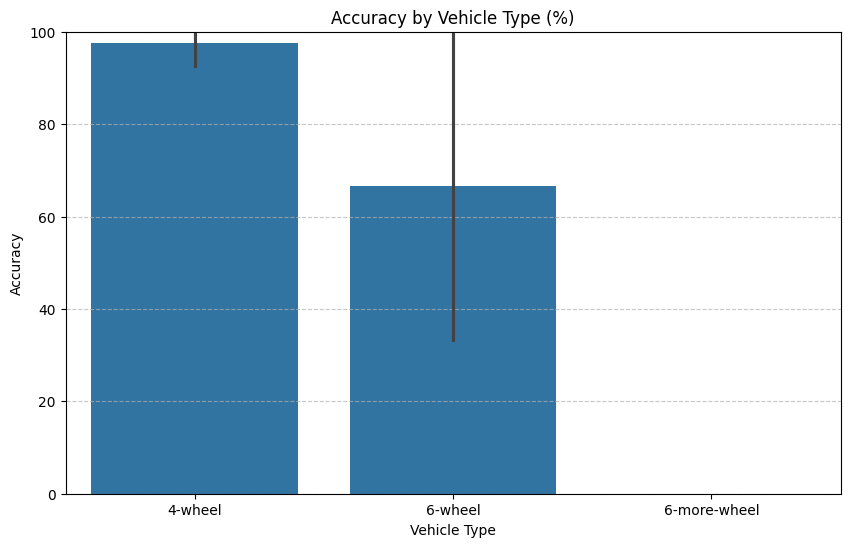

In [11]:
# Visualize per-lane accuracy
plt.figure(figsize=(12, 6))

# Bar chart for total vehicles per lane
ax1 = plt.subplot(1, 2, 1)
width = 0.35
x = merged_totals['Lane']
ax1.bar(x - width/2, merged_totals['Count_pred'], width, label='Predicted')
ax1.bar(x + width/2, merged_totals['Count_real'], width, label='Actual')
ax1.set_xlabel('Lane')
ax1.set_ylabel('Vehicle Count')
ax1.set_title('Vehicle Counts by Lane')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Bar chart for accuracy by lane
ax2 = plt.subplot(1, 2, 2)
sns.barplot(x='Lane', y='Accuracy', data=merged_totals, ax=ax2)
ax2.set_ylim([0, 100])
ax2.set_title('Accuracy by Lane (%)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Visualize vehicle type accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Vehicle Type', y='Accuracy', data=merged_detailed)
plt.ylim([0, 100])
plt.title('Accuracy by Vehicle Type (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()